In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('booksummaries.txt', sep='\t',
                 names=['id1', 'id2', 'title', 'author', 'year', 'genres', 'summary'],
                 usecols=[2, 3, 5, 6], converters={'genres' : lambda s : (list(json.loads(s).values()) if s else None)})

In [3]:
valid_genres = ['Science Fiction','Crime Fiction','Non-fiction','Children\'s literature',
                'Fantasy', 'Mystery', 'Suspense', 'Young adult literature']

In [4]:
# Iterate through each row to extract and split the list of genres
book_list = []

# Iterate through each element in the 'genres_column'
for i, row in df.iterrows():
    if row["genres"]:
        for genre in valid_genres:
            new_row={
                "title": row["title"],
                "author": row["author"],
                "summary": row["summary"]
                }
            genre_list=row["genres"]
            if genre in genre_list:
                new_row["genre"]=genre
                book_list.append(new_row)
book_df = pd.DataFrame(book_list)

In [5]:
book_df = book_df.drop_duplicates(subset=['title'])

In [6]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

book_df['genre_enc'] = encoder.fit_transform(book_df['genre'])

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer


tokenizer = Tokenizer()

corpus = [x.lower() for x in list(book_df['summary'])]

#Tokenization
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# Now, to convert text to sequences
sequences = tokenizer.texts_to_sequences(corpus)

2024-04-19 15:59:11.628755: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
#Hyper-parameters
VOCAB_SIZE = total_words
MAXLEN = 1000
BATCH_SIZE = 64
classes = len(valid_genres)

In [9]:
from keras.preprocessing import sequence

#Preprocess the dataset
sequences = sequence.pad_sequences(sequences, MAXLEN)

#get labels
labels = book_df['genre_enc']

In [10]:
from sklearn.model_selection import train_test_split

#Create training / testing data split
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=7)

In [11]:
import tensorflow as tf

#Construct LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, 32),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(128, 'relu'),
    tf.keras.layers.Dense(classes, activation="softmax")
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
#Model training
history = model.fit(X_train, y_train, validation_data = (X_test,y_test), epochs=10, batch_size = BATCH_SIZE)

Epoch 1/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 59s 560ms/step - accuracy: 0.3258 - loss: 1.8558 - val_accuracy: 0.3707 - val_loss: 1.7034
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 59s 589ms/step - accuracy: 0.3681 - loss: 1.6131 - val_accuracy: 0.4037 - val_loss: 1.5631
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 52s 516ms/step - accuracy: 0.5534 - loss: 1.1288 - val_accuracy: 0.4654 - val_loss: 1.5554
Epoch 4/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 66s 646ms/step - accuracy: 0.6633 - loss: 0.8143 - val_accuracy: 0.4168 - val_loss: 1.7440
Epoch 5/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 58s 577ms/step - accuracy: 0.7777 - loss: 0.5775 - val_accuracy: 0.4710 - val_loss: 1.9340
Epoch 6/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 55s 541ms/step - accuracy: 0.8740 - loss: 0.3691 - val_accuracy: 0.4449 - val_loss: 2.2088
Epoch 7/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 54s 532ms/step - accuracy: 0.9286 - loss: 0.2246 - val_accuracy: 0.4960 - val_loss: 2.6344
Epoch 8/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 59s 581ms/step - accuracy: 0.9595 - loss: 0

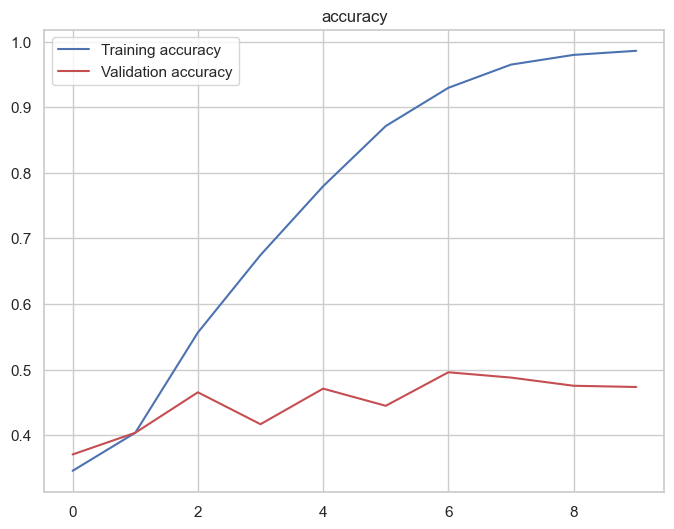

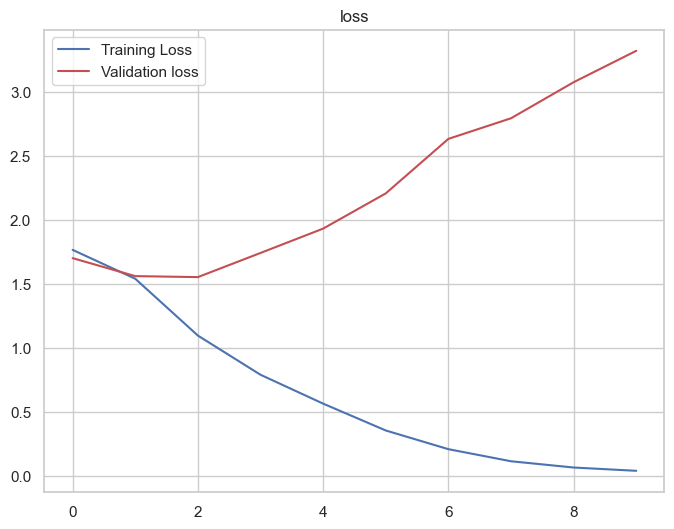

In [13]:
#Get loss and accuracy
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
#Number of training epochs
epochs = range(len(acc))
#Plot loss and accuracy
plt.figure(figsize=(8,6),dpi=100)
sns.set_theme(style='whitegrid')
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('accuracy')
plt.legend()
plt.figure(figsize=(8,6),dpi=100)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('loss')
plt.legend()

In [21]:
history_pred = history.predict(X_test)

AttributeError: 'History' object has no attribute 'predict'

In [20]:
from sklearn.metrics import classification_report, confusion_matrix

#Confusion matrix and Classification Report
def perf_eval(y_true, y_pred):
    #Classification report
    print(classification_report(y_true, y_pred,
                                target_names=list(encoder.classes_)))
    #Calculate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    #Plot the figure
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix,
                cmap='Blues',
                annot=True,
                fmt="d",
                xticklabels=list(encoder.classes_),
                yticklabels=list(encoder.classes_))
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()

In [19]:
perf_eval(y_test, history_pred)

ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets